In [24]:
!pip install wget
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tqdm
!pip install xgboost
!pip install --upgrade ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 43.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]


In [25]:
import pandas as pd
import wget
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

In [26]:
url =  'https://raw.githubusercontent.com/Veranika23/endometriosis-prediction/refs/heads/main/data/structured_endometriosis_data.csv'

In [27]:
downloaded_file = wget.download(url)

100% [.............................................] 418095 / 418095

In [28]:
df = pd.read_csv(downloaded_file)

## EDA

In [29]:
df.head()

,Age,Menstrual_Irregularity,Chronic_Pain_Level,Hormone_Level_Abnormality,Infertility,BMI,Diagnosis,Physical_activity
0,24,1,8.361531,0,0,19.451314,0,Never
1,37,1,4.995508,0,0,22.388436,0,Often
2,46,1,3.363996,1,0,21.320443,0,Never
3,32,1,5.246037,0,0,20.177715,1,Often
4,28,1,3.898932,1,0,23.538103,1,Never


In [30]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [31]:
df.head()

,age,menstrual_irregularity,chronic_pain_level,hormone_level_abnormality,infertility,bmi,diagnosis,physical_activity
0,24,1,8.361531,0,0,19.451314,0,Never
1,37,1,4.995508,0,0,22.388436,0,Often
2,46,1,3.363996,1,0,21.320443,0,Never
3,32,1,5.246037,0,0,20.177715,1,Often
4,28,1,3.898932,1,0,23.538103,1,Never


In [32]:
df.isnull().sum()

age                          0
menstrual_irregularity       0
chronic_pain_level           0
hormone_level_abnormality    0
infertility                  0
bmi                          0
diagnosis                    0
physical_activity            0
dtype: int64

In [33]:
df.dtypes

age                            int64
menstrual_irregularity         int64
chronic_pain_level           float64
hormone_level_abnormality      int64
infertility                    int64
bmi                          float64
diagnosis                      int64
physical_activity             object
dtype: object

### Checking if the model is balanced

In [34]:
df.diagnosis.value_counts()

diagnosis
0    5921
1    4079
Name: count, dtype: int64

In [35]:
df.diagnosis.mean()

np.float64(0.4079)

The target is balanced

In [36]:
numerical_columns = list(df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index)

In [37]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

In [38]:
print(f"Numerical columns are: {numerical_columns}")

Numerical columns are: ['age', 'menstrual_irregularity', 'chronic_pain_level', 'hormone_level_abnormality', 'infertility', 'bmi', 'diagnosis']


In [39]:
print(f"Categorical columns are: {categorical_columns}")

Categorical columns are: ['physical_activity']


In [41]:
for c in categorical_columns:
    df[c] = df[c].replace("_", " ").str.lower()

In [42]:
df.head()

,age,menstrual_irregularity,chronic_pain_level,hormone_level_abnormality,infertility,bmi,diagnosis,physical_activity
0,24,1,8.361531,0,0,19.451314,0,never
1,37,1,4.995508,0,0,22.388436,0,often
2,46,1,3.363996,1,0,21.320443,0,never
3,32,1,5.246037,0,0,20.177715,1,often
4,28,1,3.898932,1,0,23.538103,1,never


In [43]:
df.describe().round(0)

,age,menstrual_irregularity,chronic_pain_level,hormone_level_abnormality,infertility,bmi,diagnosis
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,34.0,1.0,5.0,1.0,0.0,23.0,0.0
std,9.0,0.0,2.0,0.0,0.0,4.0,0.0
min,18.0,0.0,0.0,0.0,0.0,15.0,0.0
25%,26.0,0.0,4.0,0.0,0.0,20.0,0.0
50%,34.0,1.0,5.0,1.0,0.0,23.0,0.0
75%,42.0,1.0,6.0,1.0,1.0,26.0,1.0
max,49.0,1.0,10.0,1.0,1.0,37.0,1.0


### Correlation

In [46]:
corr = df[numerical_columns].corr()
corr

,age,menstrual_irregularity,chronic_pain_level,hormone_level_abnormality,infertility,bmi,diagnosis
age,1.000000,-0.007918,-0.009348,-0.004070,0.014078,-0.011878,-0.011559
menstrual_irregularity,-0.007918,1.000000,0.000103,0.014647,-0.012202,0.004868,0.095197
chronic_pain_level,-0.009348,0.000103,1.000000,0.002467,0.009299,0.005755,0.116996
hormone_level_abnormality,-0.004070,0.014647,0.002467,1.000000,0.003890,-0.015499,0.187039
infertility,0.014078,-0.012202,0.009299,0.003890,1.000000,0.011529,0.096172
bmi,-0.011878,0.004868,0.005755,-0.015499,0.011529,1.000000,0.080310
diagnosis,-0.011559,0.095197,0.116996,0.187039,0.096172,0.080310,1.000000


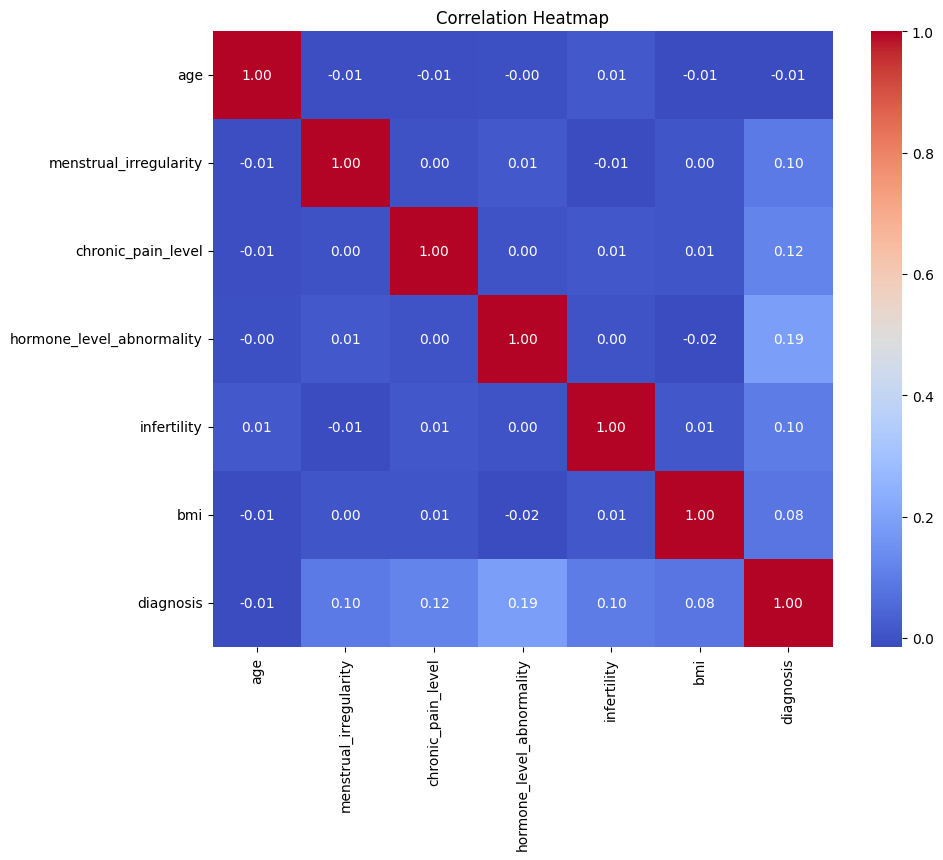

In [47]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Target variable has the highest positive correlation with chronic pain level and hormone level abnormality

### Mutual Information

In [50]:
def mutual_info_converted_score (series):
    return mutual_info_score(series, df.diagnosis.values)

In [51]:
mi = df[categorical_columns].apply(mutual_info_converted_score)
mi.sort_values(ascending = False).to_frame(name= 'mutual information')

,mutual information
physical_activity,0.000284


## Logistic regression with Scikit-Learn

In [52]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)

In [53]:
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42)

In [54]:
df_train.reset_index(drop = True)
df_val.reset_index(drop = True)
df_test.reset_index(drop = True)

,age,menstrual_irregularity,chronic_pain_level,hormone_level_abnormality,infertility,bmi,diagnosis,physical_activity
0,28,1,2.303931,1,1,19.128951,0,often
1,43,1,2.748098,1,0,24.036195,0,never
2,36,0,3.592687,1,0,25.939358,1,often
3,45,1,6.280112,0,0,17.421034,1,rarely
4,32,1,5.704050,0,0,20.698456,0,often
...,...,...,...,...,...,...,...,...
1995,40,0,4.277071,1,1,20.191541,0,often
1996,34,1,5.313937,1,0,15.425114,0,never
1997,29,1,9.234746,1,0,19.243390,0,often
1998,43,1,5.810480,1,1,21.280473,0,never


In [55]:
y_train = df_train.diagnosis.values
y_val = df_val.diagnosis.values
y_test = df_test.diagnosis.values
y_full_train = df_full_train.diagnosis.values

In [56]:
del df_train['diagnosis']
del df_val['diagnosis']
del df_test['diagnosis']

One-hot encoding

In [57]:
numerical_columns = list(df_train.dtypes[df.dtypes == 'int64'].index)

In [59]:
train_dicts = df_train[categorical_columns + numerical_columns].to_dict(orient = 'records')

In [60]:
val_dicts = df_val[categorical_columns + numerical_columns].to_dict(orient = 'records')

In [61]:
dv = DictVectorizer(sparse=False)

In [62]:
X_train = dv.fit_transform(train_dicts)

In [63]:
X_val = dv.transform(val_dicts)

In [64]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [65]:
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [66]:
y_pred = model.predict_proba(X_val)[:,1]
(y_val == (y_pred >= 0.5)).mean()

np.float64(0.601)

In [67]:
roc_auc_score(y_val, y_pred)

0.6222867451926415

### Tuning the C parameter